In [406]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from fuzzywuzzy import fuzz

pd.options.display.max_rows = 4
pd.options.display.max_colwidth = 100

import git
repo = git.Repo(path="/Users/apple/projects/kaggle/homedepot/")

In [273]:
attributes = pd.read_csv('attributes.csv')
for col in ['name', 'value']:
    attributes[col] = attributes[col].str.lower()

#TODO : Remove punctuation from the brand name

#NOTE: The word "brand" in the name usually is about the mfg brand.
#However, there are some entries about fit, compatibility and "pump brand", whatever that is.
brand_name_predicate = attributes['name'].str.contains("brand").fillna(False)
brand_names = attributes[brand_name_predicate].filter(
    items=['product_uid', 'value', 'name']).rename(columns={"value": "brand_name"})

brand_names[brand_names['brand_name'] == '.n/a'] = None
brand_names[brand_names['brand_name'].str.contains("unbranded", na=False)] = None
brand_names.dropna(subset=['brand_name'], inplace=True)

brand_filters = [brand_names['name'].str.contains(val).fillna(False)
                 for val in ["mfg", "fit", "compat", "pump"]]
mfg, fit, compat, pump = brand_filters

other = brand_names[~(mfg | fit | compat | pump)]
assert other.shape[0] == 0

mfg_brands, fit_brands, compat_brands, pump_brands = [brand_names[filt].drop('name', axis=1) for filt in brand_filters]

In [369]:
def get_brand_match(data_row):
    
    if data_row.isnull()['brand_name']:
        return 0

    search_term = data_row['search_term']
    brand_terms = data_row['brand_name'].lower().split(' ')
    
    num_matches = sum([term in search_term for term in brand_terms])
    return (1.0*num_matches) / len(brand_terms)


def get_fuzzy_brand_match(data_row):
    
    if data_row.isnull()['brand_name']:
        return 0

    return fuzz.token_set_ratio(data_row['brand_name'], data_row['search_term'])

In [264]:
#product_descriptions.csv doesn't have the "product_title" column. Augmenting it with the values from the full dataset.
train_uids = train.filter(items=['product_uid', 'product_title'])
test_uids = test.filter(items=['product_uid', 'product_title'])
data_uids = train_uids.merge(test_uids, how = "outer", on = 'product_uid')

data_uids['product_title'] = data_uids['product_title_x']
nas = data_uids['product_title'].isnull()
#The below statement throws a SettingWithCopyWarning because of the [a][b] indexing. Its safe in this case.
data_uids['product_title'][nas] = data_uids['product_title_y'][nas]
del data_uids['product_title_x'], data_uids['product_title_y']
data_uids.drop_duplicates(subset=['product_uid', 'product_title'], inplace=True)

prods = prods.merge(data_uids, how='left', on="product_uid")
prods['full_description'] = prods['product_title'] + ". " + prods['product_description']

#Add brand_name
prods = prods.merge(mfg_brands, how="left", on="product_uid")
train = train.merge(mfg_brands, how="left", on="product_uid")
test = test.merge(mfg_brands, how="left", on="product_uid")

#TODO: Modularize this entire section

#Add brand_match
for df in [train, test]:
    df['brand_match'] = df.apply(get_fuzzy_brand_match, axis=1)

uniq_lens = map(len, [np.unique(df['product_uid'].values) for df in [prods, data_uids, train, test]])
assert uniq_lens[0] == uniq_lens[1]

#We have title dupes
print(len(np.unique(data_uids['product_uid'].values)))
print(len(np.unique(data_uids['product_title'].values)))

124428
120348


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
#This extracts the term counts per product description + title
tf_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode', decode_error='replace')
full_desc = prods['full_description']
tf = tf_vectorizer.fit_transform(full_desc)

In [6]:
#Should grid-search on max_iter, n_topics, learning_*, batch_size
#TODO : Do we have any meaningful topic priors? A uniform dirichlet with concentration param < 1 seems natural here.
#TODO : The default conc. param is 1/n_topics. What does this imply?
#TODO : Separate the brand out into another variable. Don't have it participate in the lda.
lda = LatentDirichletAllocation(n_topics=10, max_iter=5, verbose=5, n_jobs=8, batch_size=2500)
topic_dists = lda.fit_transform(tf)

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]

LatentDirichletAllocation(batch_size=2500, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=8, n_topics=10, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=5)

In [395]:
#From the sklearn topic extraction example
def print_top_words(model, feature_names, n_top_words, thold=0.01):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(topic_idx))
        print(" ".join([feature_names[i] + "(%.2lf)" % (topic[i]/sum(topic))  
                        for i in topic.argsort()[:-n_top_words - 1:-1]
                           if topic[i] >= thold*sum(topic) ]))

In [396]:
feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, feature_names, 10)
#TODO : The data is shitty, as someone pointed out on the forum. Might need to filter things like
#mmnumber, 2sink, screwdriverada, acrylicwater, bracketsoptional, awningtime...

Topic #0:
easy(0.84) mmnumber(0.06) 2sink(0.05) finish(0.03)
Topic #1:
steel(0.77) door(0.17) easy(0.05)
Topic #2:
whitewall(0.99)
Topic #3:
ft(0.91) easy(0.07) steel(0.01)
Topic #4:
mpi(0.97)
Topic #5:
efv(1.00)
Topic #6:
presto(0.65) plastpro(0.34)
Topic #7:
mixet(0.99)
Topic #8:
use(0.47) light(0.28) steel(0.18) easy(0.03) water(0.01)
Topic #9:
efv(0.50) plastpro(0.50)


In [407]:
#topic_dists will is the distribution you get from transforming your product descriptions using your model.
#For example, if using lda, you will countVectorize the product descriptions and then fit this to an lda model.
#topic_dists will be this model's transform of the countVectorized data.

#TODO : We are assuming that df['product_uid'] - 100001 corresponds to the row-index of topic_dists

#TODO : The normalized topic_dists fall off exponentially. So might make sense to work with their log when
#plugging them into a regression model.

def augment_with_topic_dist(df, topic_dists, prefix, inplace=False, use_row_inds=False):
    
    frame = None
    if inplace:
        frame = df
    else:
        frame = df.copy()
    
    #Normalize the row-sums of topic_dists to 1
    #TODO : Does this make sense though? Aren't these the dirichlet alpha's?
    dist_sums = topic_dists.sum(axis=1).reshape(len(topic_dists), 1)
    topic_dists_normed = topic_dists / dist_sums
    
    assert not use_row_inds or (len(frame) == len(topic_dists))
    inds = np.arange(len(frame)) if use_row_inds else (frame['product_uid'] - 100001)
    
    for feat_num in range(topic_dists_normed.shape[1]):
        frame['{}_{}'.format(prefix, feat_num)] = topic_dists_normed[inds, feat_num] 
    
    return frame


#TODO : How do we extract the topic distributions for the search terms if they contain words not in the product_descs?
#data should be a iterable of strings to transform
def get_topic_dists(data, model, vectorizer):

    data_tf = vectorizer.transform(data)
    return model.transform(data_tf)


def get_reg_data(df, model, vectorizer, prod_desc_dists):
    
    search_dists = get_topic_dists(df['search_term'], model, vectorizer)
    aug_df = augment_with_topic_dist(df, prod_desc_dists, "prod_dist")
    aug_df = augment_with_topic_dist(aug_df, search_dists, "search_dist", use_row_inds=True)
    
    x = aug_df.filter(regex="_dist_[0-9]|brand_match")
    y = None
    try:
        y = np.ravel(aug_df['relevance'])
    except:
        print "No targets"

    return x, y

def write_submission(test_data, pred, fname = "predictions.csv", git_repo = None):
    
    submit_df = pd.DataFrame(columns=["id", "relevance"])
    submit_df['id'] = test['id']

    clipped_pred = np.clip(pred, 1.0, 3.0)
    submit_df['relevance'] = clipped_pred
    
    submit_df.columns = ['"' + col + '"' for col in submit_df.columns]
    submit_df.to_csv(fname, index=False, quotechar='\\')
    
    if git_repo:
        git_repo.git.commit(a=True, m="Latest predictions.\n\nTODO : Add train and validation stats here.")
    
    return submit_df

In [ ]:
#TODO : Right now, we have no test set. Need to hold out part of the train
train_x, train_y = get_reg_data(train, lda, tf_vectorizer, topics)
test_x, test_y = get_reg_data(test, lda, tf_vectorizer, topics)

relevance_reg = ensemble.GradientBoostingRegressor(n_estimators=163, subsample=0.8, max_depth=4, verbose=1,
                                                   learning_rate=0.1, min_samples_split=2)
relevance_reg.fit(train_x, train_y)

pred_y = relevance_reg.predict(test_x)
write_submission(test, pred_y, git_repo=repo)

(0.0096427138266309553, 0.0021071324290892757, 0.018224893816375709, 163)

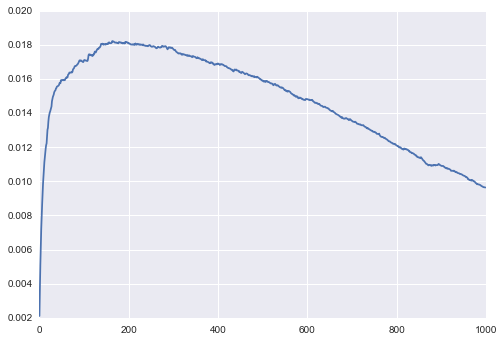

In [436]:
ob = np.cumsum(relevance_reg.oob_improvement_)
plt.plot(ob)
bestind = np.argsort(ob)[::-1][0]
ob[-1], ob[0], ob[bestind], bestind